In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [32]:
train_df = pd.read_csv("C:/Users/David/Documents/Albert school/ML/playground-series-s4e10/train.csv", index_col="id")
test_df = pd.read_csv("C:/Users/David/Documents/Albert school/ML/playground-series-s4e10/test.csv", index_col="id")
submission_df = pd.read_csv("C:/Users/David/Documents/Albert school/ML/playground-series-s4e10/sample_submission.csv", index_col="id")


In [251]:
train_df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1


Data Cleaning

In [252]:
train_df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [253]:
train_df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [310]:
train_df.shape

(58645, 12)

Pipeline pour calculer le taux de succès de mes variables


assert vérifie que l'attribut existe dans les colonnes du DataFrame.
groupby regroupe les données par cet attribut et calcule le total et le nombre de prêts approuvés (loan_status).
success_rate est calculé en divisant les prêts approuvés par le total, exprimé en pourcentage.
try-except capture les erreurs et affiche un message en cas de problème.

In [254]:
def success_rate_pipeline(attribute):
    assert attribute in train_df.columns, "no attribute"
    try:
        # Regroupement par l'attribut et calcul des totaux et des approbations
        attribute_success_rate_df = train_df.groupby(attribute).agg(
            total=('loan_status', 'count'), 
            approved=('loan_status', 'sum')
        ).reset_index()

        # Calcul du taux de succès
        attribute_success_rate_df['success_rate'] = attribute_success_rate_df['approved'] / attribute_success_rate_df['total'] * 100
        
        print(attribute_success_rate_df)
    except Exception as e:
        print(f"Exception: {e}")


person_home_ownership

In [255]:
train_df['person_home_ownership'].value_counts()

person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64

In [256]:
success_rate_pipeline('person_home_ownership')

  person_home_ownership  total  approved  success_rate
0              MORTGAGE  24824      1483      5.974057
1                 OTHER     89        15     16.853933
2                   OWN   3138        43      1.370300
3                  RENT  30594      6809     22.255998


Encodage avec onehotencoding car pas de lien entre les variables

In [257]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# Créer une copie de train_df pour conserver les données de base
train_copy = train_df.copy()

# Initialisation de l'encodeur OrdinalEncoder
encoder = OrdinalEncoder()

# Appliquer l'encodage sur la colonne 'person_home_ownership'
train_copy['person_home_ownership'] = encoder.fit_transform(train_copy[['person_home_ownership']])

# Affichage des premières lignes du DataFrame encodé
print(train_copy.head())


    person_age  person_income  person_home_ownership  person_emp_length  \
id                                                                        
0           37          35000                    3.0                0.0   
1           22          56000                    2.0                6.0   
2           29          28800                    2.0                8.0   
3           30          70000                    3.0               14.0   
4           22          60000                    3.0                2.0   

   loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
id                                                                         
0    EDUCATION          B       6000          11.49                 0.17   
1      MEDICAL          C       4000          13.35                 0.07   
2     PERSONAL          A       6000           8.90                 0.21   
3      VENTURE          B      12000          11.11                 0.17   
4      MEDICAL    

loan_intent

In [258]:
train_copy['loan_intent'].value_counts()

loan_intent
EDUCATION            12271
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64

In [259]:
success_rate_pipeline('loan_intent')

         loan_intent  total  approved  success_rate
0  DEBTCONSOLIDATION   9133      1729     18.931348
1          EDUCATION  12271      1322     10.773368
2    HOMEIMPROVEMENT   6280      1091     17.372611
3            MEDICAL  10934      1949     17.825133
4           PERSONAL  10016      1330     13.278754
5            VENTURE  10011       929      9.279792


In [260]:
# Initialisation de l'encodeur OrdinalEncoder
encoder = OrdinalEncoder()

# Appliquer l'encodage sur la colonne 'loan_intent'
train_copy['loan_intent'] = encoder.fit_transform(train_copy[['loan_intent']])

# Affichage des premières lignes du DataFrame encodé
print(train_copy.head())

    person_age  person_income  person_home_ownership  person_emp_length  \
id                                                                        
0           37          35000                    3.0                0.0   
1           22          56000                    2.0                6.0   
2           29          28800                    2.0                8.0   
3           30          70000                    3.0               14.0   
4           22          60000                    3.0                2.0   

    loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
id                                                                          
0           1.0          B       6000          11.49                 0.17   
1           3.0          C       4000          13.35                 0.07   
2           4.0          A       6000           8.90                 0.21   
3           5.0          B      12000          11.11                 0.17   
4           

loan_grade

In [261]:
train_copy['loan_grade'].value_counts()

loan_grade
A    20984
B    20400
C    11036
D     5034
E     1009
F      149
G       33
Name: count, dtype: int64

In [262]:
success_rate_pipeline('loan_grade')

  loan_grade  total  approved  success_rate
0          A  20984      1032      4.918033
1          B  20400      2087     10.230392
2          C  11036      1494     13.537514
3          D   5034      2988     59.356377
4          E   1009       631     62.537166
5          F    149        91     61.073826
6          G     33        27     81.818182


In [263]:
from sklearn.preprocessing import OrdinalEncoder

# Initialisation de l'encodeur OrdinalEncoder avec l'ordre spécifique
encoder = OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']])

# Appliquer l'encodage ordinal sur la colonne 'loan_grade' avec l'ordre spécifié
train_copy['loan_grade'] = encoder.fit_transform(train_copy[['loan_grade']])

# Affichage des premières lignes du DataFrame encodé
print(train_copy.head())


    person_age  person_income  person_home_ownership  person_emp_length  \
id                                                                        
0           37          35000                    3.0                0.0   
1           22          56000                    2.0                6.0   
2           29          28800                    2.0                8.0   
3           30          70000                    3.0               14.0   
4           22          60000                    3.0                2.0   

    loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
id                                                                           
0           1.0         1.0       6000          11.49                 0.17   
1           3.0         2.0       4000          13.35                 0.07   
2           4.0         0.0       6000           8.90                 0.21   
3           5.0         1.0      12000          11.11                 0.17   
4     

cb_person_default_on_file¶

In [264]:
train_copy['cb_person_default_on_file'].value_counts()

cb_person_default_on_file
N    49943
Y     8702
Name: count, dtype: int64

In [265]:
success_rate_pipeline('cb_person_default_on_file')

  cb_person_default_on_file  total  approved  success_rate
0                         N  49943      5749     11.511123
1                         Y   8702      2601     29.889681


In [266]:
# Initialisation de l'encodeur OrdinalEncoder
encoder = OrdinalEncoder()

# Appliquer l'encodage sur la colonne 'cb_person_default_on_file'
train_copy['cb_person_default_on_file'] = encoder.fit_transform(train_copy[['cb_person_default_on_file']])

# Affichage des premières lignes du DataFrame encodé
print(train_copy.head())

    person_age  person_income  person_home_ownership  person_emp_length  \
id                                                                        
0           37          35000                    3.0                0.0   
1           22          56000                    2.0                6.0   
2           29          28800                    2.0                8.0   
3           30          70000                    3.0               14.0   
4           22          60000                    3.0                2.0   

    loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
id                                                                           
0           1.0         1.0       6000          11.49                 0.17   
1           3.0         2.0       4000          13.35                 0.07   
2           4.0         0.0       6000           8.90                 0.21   
3           5.0         1.0      12000          11.11                 0.17   
4     

person_age

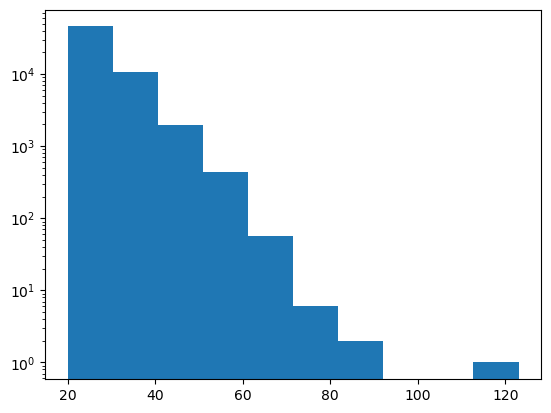

In [267]:
plt.hist(train_copy['person_age'])
plt.yscale('log')

In [268]:
range_in_age = (train_copy['person_age'] >= 20) & (train_copy['person_age'] <= 100)

person_income

Text(0.5, 1.0, 'income')

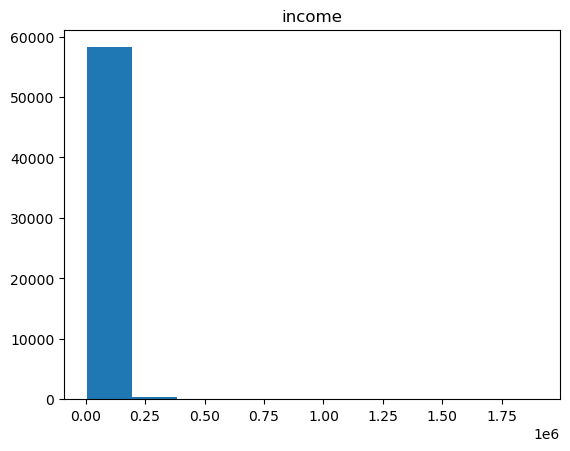

In [269]:
plt.hist(train_copy['person_income'])
plt.title('income')


Ce code crée un histogramme des revenus (person_income) et applique une échelle logarithmique à l'axe y pour mieux visualiser les variations dans les fréquences.

plt.hist(data['person_income']) : Affiche un histogramme des valeurs de la colonne person_income.
plt.title('log_income') : Ajoute le titre "log_income" au graphique.
plt.yscale('log') : Définit l'axe y sur une échelle logarithmique pour mieux représenter les différences de fréquence.

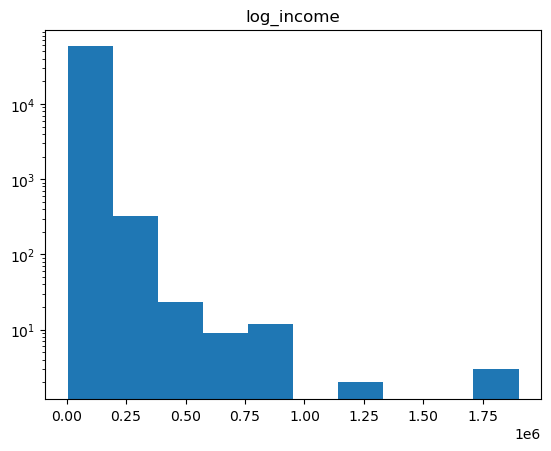

In [270]:
plt.hist(train_copy['person_income'])
plt.title('log_income')
plt.yscale('log')

person_emp_length

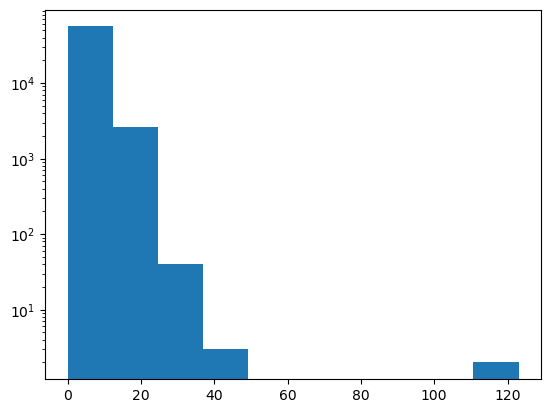

In [271]:
plt.hist(train_copy['person_emp_length'])
plt.yscale('log')

pas de personne qui taffe après 60

In [272]:
range_in_employment = ((train_copy['person_emp_length'] >= 0) & (train_copy['person_emp_length'] <= 60))

In [273]:
train_cleaned = train_copy[range_in_age & range_in_employment]
train_cleaned = train_copy[train_copy['loan_int_rate'].notna()]
train_cleaned = train_copy.drop_duplicates()
train_cleaned

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,3.0,0.0,1.0,1.0,6000,11.49,0.17,0.0,14,0
1,22,56000,2.0,6.0,3.0,2.0,4000,13.35,0.07,0.0,2,0
2,29,28800,2.0,8.0,4.0,0.0,6000,8.90,0.21,0.0,10,0
3,30,70000,3.0,14.0,5.0,1.0,12000,11.11,0.17,0.0,5,0
4,22,60000,3.0,2.0,3.0,0.0,6000,6.92,0.10,0.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,0.0,5.0,1.0,3.0,25000,15.95,0.21,1.0,10,0
58641,28,28800,3.0,0.0,3.0,2.0,10000,12.73,0.35,0.0,8,1
58642,23,44000,3.0,7.0,1.0,3.0,6800,16.00,0.15,0.0,2,1


Correlation

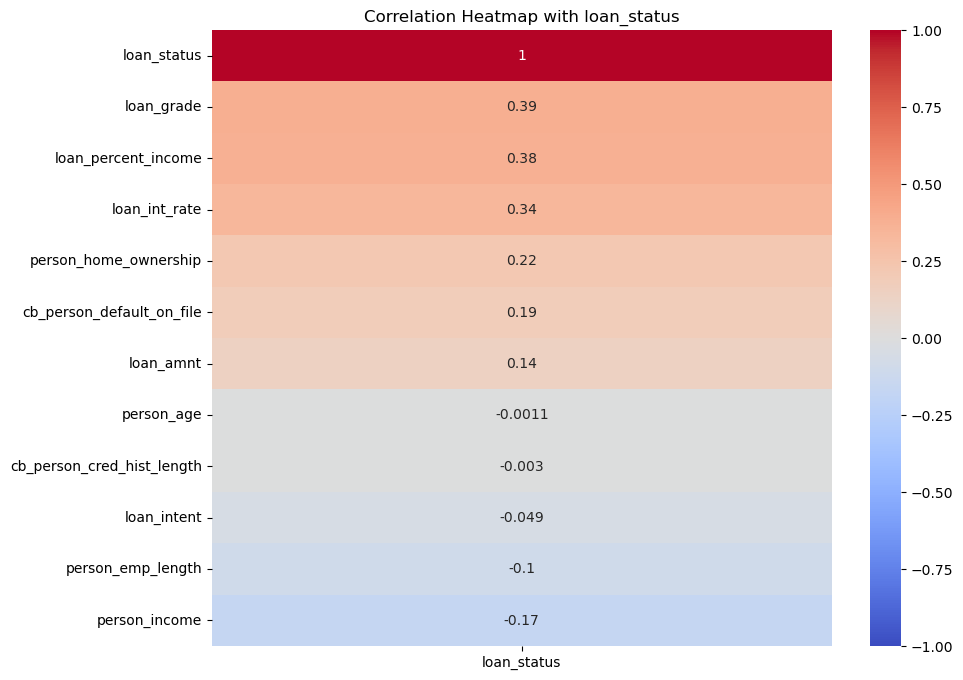

In [274]:
import seaborn as sns  # Importation correcte de seaborn
import matplotlib.pyplot as plt  # Importation de matplotlib pour l'affichage

# Calculer la matrice de corrélation
corr_matrix = train_cleaned.corr()

# Filtrer pour ne garder que les corrélations avec la cible "loan_status"
target_corr = corr_matrix[["loan_status"]].sort_values(by="loan_status", ascending=False)

# Créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(target_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap with loan_status")
plt.show()


In [275]:
train_cleaned

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,3.0,0.0,1.0,1.0,6000,11.49,0.17,0.0,14,0
1,22,56000,2.0,6.0,3.0,2.0,4000,13.35,0.07,0.0,2,0
2,29,28800,2.0,8.0,4.0,0.0,6000,8.90,0.21,0.0,10,0
3,30,70000,3.0,14.0,5.0,1.0,12000,11.11,0.17,0.0,5,0
4,22,60000,3.0,2.0,3.0,0.0,6000,6.92,0.10,0.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,0.0,5.0,1.0,3.0,25000,15.95,0.21,1.0,10,0
58641,28,28800,3.0,0.0,3.0,2.0,10000,12.73,0.35,0.0,8,1
58642,23,44000,3.0,7.0,1.0,3.0,6800,16.00,0.15,0.0,2,1


verif si ID est un idex ou une colonne, si index pas besoin de suppr

In [276]:
print(train_cleaned.index)  # Vérifiez si l'index est 'id'

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       58635, 58636, 58637, 58638, 58639, 58640, 58641, 58642, 58643, 58644],
      dtype='int64', name='id', length=58645)


verif type de mes colonnes et valeur manquante

In [277]:
# Vérifier les types de colonnes dans le DataFrame
print(train_cleaned.dtypes)


person_age                      int64
person_income                   int64
person_home_ownership         float64
person_emp_length             float64
loan_intent                   float64
loan_grade                    float64
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file     float64
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object


In [278]:
missing_values = train_cleaned.isnull().sum()

# Afficher les colonnes avec des valeurs manquantes
print("Colonnes avec des valeurs manquantes :")
print(missing_values[missing_values > 0])

Colonnes avec des valeurs manquantes :
Series([], dtype: int64)


Machine learning

baseline

In [279]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [280]:
# Séparer les features (X) et la target (y)
X = train_cleaned.drop(columns='loan_status')  # Supposons que 'loan_status' soit la cible
y = train_cleaned['loan_status']



In [281]:
# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [282]:
# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [283]:
# Initialiser le modèle de régression logistique
model = LogisticRegression(max_iter=2000)


In [ ]:
tracking_uri = mlflow.get_tracking_uri()  # Stocke le tracking URI dans une variable
print(tracking_uri)  # Affiche le tracking URI si besoin



file:///c:/Users/David/Documents/Albert%20school/ML/playground-series-s4e10/mlruns


In [ ]:
mlflow.set_tracking_uri(tracking_uri)  # Définit le tracking URI à partir de la variable


verif

In [287]:
mlflow.end_run()

In [288]:
with mlflow.start_run() as run:
    print(f"Run ID: {run.info.run_id}")
    print(f"Experiment ID: {run.info.experiment_id}")


Run ID: e8e3a08d937f489d841a6edd3ea91f5c
Experiment ID: 823457168198047015


In [289]:
mlflow.set_tracking_uri("file:///c:/Users/David/Documents/Albert%20school/ML/playground-series-s4e10/mlruns")


In [290]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Set the name of the experiment
mlflow.set_experiment("Devoir de ML, Loan approval")

# Enable MLflow autologging for all supported libraries (including scikit-learn)
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.)
X = train_cleaned.drop(columns='loan_status')
y = train_cleaned['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="Logistic Regression Baseline"):
    # Model training
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Make predictions and calculate metrics
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    # Log the ROC AUC score manually (since this is custom)
    mlflow.log_metric("roc_auc", roc_auc)

    # Output the ROC AUC score
    print(f"ROC AUC Score: {roc_auc}")


2024/10/23 10:30:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:30:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:30:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/10/23 10:30:46 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


ROC AUC Score: 0.8801397392019517


fonction dans le cmd : cd C:\Users\David\Documents\Albert school\ML\playground-series-s4e10
cd mlflow ui

On va tester plusieurs model
random forest

In [291]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Enable MLflow autologging
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.)
X = train_cleaned.drop(columns='loan_status')
y = train_cleaned['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="Random Forest classique"):
    # Model training
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions and calculate metrics
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    # Log the ROC AUC score manually
    mlflow.log_metric("roc_auc", roc_auc)

    # Output the ROC AUC score
    print(f"ROC AUC Score: {roc_auc}")


2024/10/23 10:30:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:30:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:30:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/10/23 10:30:51 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


ROC AUC Score: 0.9407866240926834


Gradient boosting

In [292]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Enable MLflow autologging
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.)
X = train_cleaned.drop(columns='loan_status')
y = train_cleaned['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="Gradient Boosting classique"):
    # Model training
    model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions and calculate metrics
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    # Log the ROC AUC score manually
    mlflow.log_metric("roc_auc", roc_auc)

    # Output the ROC AUC score
    print(f"ROC AUC Score: {roc_auc}")


2024/10/23 10:31:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:31:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:31:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/10/23 10:31:03 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


ROC AUC Score: 0.9428324067820678


svm
SVM works by finding a hyperplane that best separates classes in a high-dimensional space. It can work well for both linear and non-linear data (with the use of kernels).

In [293]:
import mlflow
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Enable MLflow autologging
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.)
X = train_cleaned.drop(columns='loan_status')
y = train_cleaned['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="SVM classique"):
    # Model training with SVM (using probability=True to calculate ROC AUC)
    model = SVC(probability=True, random_state=42)

    # Add progress bar during training
    # Here we simulate iterations for SVM (which internally doesn't have a progress method)
    # For SVM, the fitting process doesn't have inherent progress tracking, so we wrap it with tqdm
    with tqdm(total=1, desc="Training SVM", unit="step") as pbar:
        model.fit(X_train_scaled, y_train)
        pbar.update(1)  # SVM fitting completes in one "step"

    # Make predictions and calculate metrics
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    # Log the ROC AUC score manually
    mlflow.log_metric("roc_auc", roc_auc)

    # Output the ROC AUC score
    print(f"ROC AUC Score: {roc_auc}")


2024/10/23 10:31:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:31:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:31:19 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
Training SVM: 100%|██████████| 1/1 [04:56<00:00, 296.12s/step]


ROC AUC Score: 0.8702789688298889


KNN
Description: KNN is a simple, instance-based learning algorithm that classifies a data point based on how its neighbors are classified.

In [294]:
from sklearn.neighbors import KNeighborsClassifier

# Enable MLflow autologging
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.)
X = train_cleaned.drop(columns='loan_status')
y = train_cleaned['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="KNN classique"):
    # Model training with KNN (default n_neighbors=5)
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train_scaled, y_train)

    # Make predictions and calculate metrics
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    # Log the ROC AUC score manually
    mlflow.log_metric("roc_auc", roc_auc)

    # Output the ROC AUC score
    print(f"ROC AUC Score: {roc_auc}")


2024/10/23 10:36:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:36:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:36:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/10/23 10:36:22 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


ROC AUC Score: 0.8774741659861278


xgboost
Description: XGBoost is an optimized gradient boosting algorithm that often performs well in Kaggle competitions and practical applications.

In [295]:
import xgboost as xgb

# Enable MLflow autologging
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.)
X = train_cleaned.drop(columns='loan_status')
y = train_cleaned['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="XGBoost classique"):
    # Model training with XGBoost
    model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions and calculate metrics
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    # Log the ROC AUC score manually
    mlflow.log_metric("roc_auc", roc_auc)

    # Output the ROC AUC score
    print(f"ROC AUC Score: {roc_auc}")


2024/10/23 10:36:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:36:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:36:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


ROC AUC Score: 0.9554077153611329


Neural Networks (MLP - Multi-layer Perceptron)
Description: A simple feedforward neural network with one or more hidden layers. It's useful when the data has complex, non-linear relationships.

In [296]:
from sklearn.neural_network import MLPClassifier

# Enable MLflow autologging
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.)
X = train_cleaned.drop(columns='loan_status')
y = train_cleaned['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="MLP Neural Network classique"):
    # Model training with MLPClassifier
    model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions and calculate metrics
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    # Log the ROC AUC score manually
    mlflow.log_metric("roc_auc", roc_auc)

    # Output the ROC AUC score
    print(f"ROC AUC Score: {roc_auc}")


2024/10/23 10:36:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:36:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:36:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/10/23 10:36:50 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


ROC AUC Score: 0.9320001854752811


ADA boost
Description: A boosting algorithm that combines weak classifiers to form a strong classifier. Each classifier focuses on examples that previous classifiers missed.

In [297]:
from sklearn.ensemble import AdaBoostClassifier

# Enable MLflow autologging
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.)
X = train_cleaned.drop(columns='loan_status')
y = train_cleaned['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="AdaBoost classique"):
    # Model training with AdaBoostClassifier
    model = AdaBoostClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions and calculate metrics
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    # Log the ROC AUC score manually
    mlflow.log_metric("roc_auc", roc_auc)

    # Output the ROC AUC score
    print(f"ROC AUC Score: {roc_auc}")


2024/10/23 10:37:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:37:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:37:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/10/23 10:37:41 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


ROC AUC Score: 0.9266906536759908


Catboost
Description: Another gradient boosting algorithm like XGBoost and LightGBM, but with specific optimization for categorical features.

In [298]:
from catboost import CatBoostClassifier

# Enable MLflow autologging
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.)
X = train_cleaned.drop(columns='loan_status')
y = train_cleaned['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="CatBoost classique"):
    # Model training with CatBoostClassifier
    model = CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42, verbose=0)
    model.fit(X_train_scaled, y_train)

    # Make predictions and calculate metrics
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    # Log the ROC AUC score manually
    mlflow.log_metric("roc_auc", roc_auc)

    # Output the ROC AUC score
    print(f"ROC AUC Score: {roc_auc}")


2024/10/23 10:37:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:37:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:37:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


ROC AUC Score: 0.9446165497806114


XGBoost a le meilleur résultat avec 0.9554077153611329 pour le roc auc

Plusieurs idée :
kfold ?
optuna 
et rajouter des colonnes comme :
loan_to_income_ratio: Le rapport entre le montant du prêt et le revenu de la personne
interest_income_ratio: Le rapport entre le taux d'intérêt et le revenu de la personne
employment_income_ratio: Le rapport entre la durée d'emploi et le revenu

on commence avec kfold, on regarde le meilleure score et le mean, le mean est plus important ici, empeche l'overfitting et permet de smooth out les variability des subsets

In [299]:
from sklearn.model_selection import StratifiedKFold

# Enable MLflow autologging
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.)
X = train_cleaned.drop(columns='loan_status')
y = train_cleaned['loan_status']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5)

# Initialize list to store AUC scores
auc_scores = []

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="XGBoost avec KFold"):
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y)):
        # Split the data into training and testing sets
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Model training with XGBoost
        model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
        model.fit(X_train, y_train)

        # Make predictions and calculate metrics
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        auc_scores.append(roc_auc)

    # Log the mean ROC AUC score across all folds
    mean_auc = np.mean(auc_scores)
    mlflow.log_metric("mean_roc_auc", mean_auc)


    # Output the mean and best ROC AUC score
    print(f"Mean ROC AUC Score: {mean_auc}")
    print(f"Best ROC AUC Score: {best_auc}")


2024/10/23 10:37:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:37:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:37:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


Mean ROC AUC Score: 0.9537613231633959
Best ROC AUC Score: 0.956246695395371


le best est supérieur au xgboost sans kfold, le mean legerement en dessous, on va garder le mean

ajout des colonnes :
loan_to_income_ratio: Le rapport entre le montant du prêt et le revenu de la personne
interest_income_ratio: Le rapport entre le taux d'intérêt et le revenu de la personne
employment_income_ratio: Le rapport entre la durée d'emploi et le revenu

In [300]:
# Create a copy of the original dataset
train_cleanedV2 = train_cleaned.copy()

# Calculate new features
train_cleanedV2['loan_to_income_ratio'] = train_cleanedV2['loan_amnt'] / train_cleanedV2['person_income']


# Display the first few rows of the new dataset
print(train_cleanedV2.head())


    person_age  person_income  person_home_ownership  person_emp_length  \
id                                                                        
0           37          35000                    3.0                0.0   
1           22          56000                    2.0                6.0   
2           29          28800                    2.0                8.0   
3           30          70000                    3.0               14.0   
4           22          60000                    3.0                2.0   

    loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
id                                                                           
0           1.0         1.0       6000          11.49                 0.17   
1           3.0         2.0       4000          13.35                 0.07   
2           4.0         0.0       6000           8.90                 0.21   
3           5.0         1.0      12000          11.11                 0.17   
4     

In [301]:
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.) using train_cleanedV2
X = train_cleanedV2.drop(columns='loan_status')
y = train_cleanedV2['loan_status']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5)

# Initialize list to store AUC scores
auc_scores = []

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="XGBoost avec KFold sur train_cleanedV2"):
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y)):
        # Split the data into training and testing sets
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Model training with XGBoost
        model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
        model.fit(X_train, y_train)

        # Make predictions and calculate metrics
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        auc_scores.append(roc_auc)

    # Log the mean ROC AUC score across all folds
    mean_auc = np.mean(auc_scores)
    mlflow.log_metric("mean_roc_auc", mean_auc)

    # Output the mean ROC AUC score
    print(f"Mean ROC AUC Score: {mean_auc}")


2024/10/23 10:38:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:38:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:38:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


Mean ROC AUC Score: 0.9527772846790761


Logiquement il faudrait savoir il reste combien à la personne à la fin du mois pour savoir si le pret est possible ( supposition loan sur 1 an)

This code calculates two new columns: total_due_with_loan_amnt, which is the loan amount plus the interest, and remaining_income_end_of_month, which is the remaining income after paying the total due, divided by 12 to get the monthly value, and then prints the results.

In [302]:
# Create the 'total_due_with_loan_amnt' column without creating 'total_due'
train_cleanedV2['total_due_with_loan_amnt'] = (train_cleanedV2['loan_amnt'] * (train_cleanedV2['loan_int_rate'] / 100)) + train_cleanedV2['loan_amnt']

# 3. Create the 'remaining_income_end_of_month' column (person_income - total_due_with_loan_amnt) / 12
train_cleanedV2['remaining_income_end_of_month'] = (train_cleanedV2['person_income'] - train_cleanedV2['total_due_with_loan_amnt']) / 12

# Display the first few rows to verify the new columns
print(train_cleanedV2[['total_due_with_loan_amnt', 'remaining_income_end_of_month']].head())


    total_due_with_loan_amnt  remaining_income_end_of_month
id                                                         
0                     6689.4                    2359.216667
1                     4534.0                    4288.833333
2                     6534.0                    1855.500000
3                    13333.2                    4722.233333
4                     6415.2                    4465.400000


In [303]:
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.) using train_cleanedV2
X = train_cleanedV2.drop(columns='loan_status')
y = train_cleanedV2['loan_status']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5)

# Initialize list to store AUC scores
auc_scores = []

# Start the MLflow run with a custom run name
with mlflow.start_run(run_name="XGBoost avec KFold sur train_cleanedV3"):
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y)):
        # Split the data into training and testing sets
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Model training with XGBoost
        model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
        model.fit(X_train, y_train)

        # Make predictions and calculate metrics
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        auc_scores.append(roc_auc)

    # Log the mean ROC AUC score across all folds
    mean_auc = np.mean(auc_scores)
    mlflow.log_metric("mean_roc_auc", mean_auc)

    # Output the mean ROC AUC score
    print(f"Mean ROC AUC Score: {mean_auc}")


2024/10/23 10:38:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/10/23 10:38:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:38:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


Mean ROC AUC Score: 0.951907833602107


score moins bon mais convenable

test avec optuna

In [307]:
import optuna
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Enable MLflow autologging
mlflow.autolog()

# Data preparation steps (X and y split, scaling, etc.) using train_cleanedV2
X = train_cleanedV2.drop(columns='loan_status')
y = train_cleanedV2['loan_status']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5)

# Define the objective function for Optuna
def objective(trial):
    auc_scores = []

    # Define hyperparameters to optimize
    param = {
    'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
    'max_depth': trial.suggest_int('max_depth', 5, 15),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
    'gamma': trial.suggest_float('gamma', 0.0, 1.0),
    'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
    'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 3.0),
    'enable_categorical': True,
    'verbosity': 0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 42,
    'use_label_encoder': False
}


    # K-Fold Cross-Validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y)):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Model training with XGBoost
        model = xgb.XGBClassifier(**param)
        model.fit(X_train, y_train)

        # Make predictions and calculate metrics
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        auc_scores.append(roc_auc)

    # Return the mean ROC AUC score across all folds
    mean_auc = np.mean(auc_scores)
    return mean_auc

# Create an Optuna study and optimize with a progress bar for Optuna trials
study = optuna.create_study(direction='maximize')
with mlflow.start_run(run_name="XGBoost with Optuna"):
    for _ in tqdm(range(100), desc="Optuna Trials Progress"):  # Progress for the number of trials
        study.optimize(objective, n_trials=1, catch=(ValueError,))

# Log the best parameters and best ROC AUC score
best_params = study.best_params
best_auc = study.best_value
mlflow.log_params(best_params)
mlflow.log_metric("best_roc_auc", best_auc)

# Output the best results
print(f"Best ROC AUC Score: {best_auc}")
print(f"Best Parameters: {best_params}")


2024/10/23 10:41:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


2024/10/23 10:41:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/23 10:41:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
[I 2024-10-23 10:41:52,898] A new study created in memory with name: no-name-6c262386-1814-4c76-a74f-591405daed42
Optuna Trials Progress:   1%|          | 1/100 [00:51<1:24:29, 51.21s/it]2024/10/23 10:42:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 4af20c165cba4f95b2a0842a3b182ddb. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'colsample_bytree\' was already logged with value=\'0.6202798122887931\' for run ID=\'4af20c165cba4f95b2a0842a3b182ddb\'. Attempted logging new value \'0.9186495621712853\'.")]')]
2024/10/23 10:42:52 WARNING mlflow.uti

Best ROC AUC Score: 0.9554944152851469
Best Parameters: {'n_estimators': 810, 'max_depth': 9, 'learning_rate': 0.028618560373904076, 'subsample': 0.9387878631101017, 'colsample_bytree': 0.5346764671975038, 'reg_lambda': 2.414168504239591, 'gamma': 0.8734114631567977, 'reg_alpha': 0.9363000439395364, 'min_child_weight': 20, 'scale_pos_weight': 1.501298684558463}


0.9549 oklm, teste sur le dataset test pour voir résultat sur kaggle

In [127]:
train_cleanedV2

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loan_to_income_ratio,remaining_income_end_of_month,total_due_with_loan_amnt
id,,,,,,,,,,,,,,,
0,37,35000,3.0,0.0,1.0,1.0,6000,11.49,0.17,0.0,14,0,0.171429,2359.216667,6689.4
1,22,56000,2.0,6.0,3.0,2.0,4000,13.35,0.07,0.0,2,0,0.071429,4288.833333,4534.0
2,29,28800,2.0,8.0,4.0,0.0,6000,8.90,0.21,0.0,10,0,0.208333,1855.500000,6534.0
3,30,70000,3.0,14.0,5.0,1.0,12000,11.11,0.17,0.0,5,0,0.171429,4722.233333,13333.2
4,22,60000,3.0,2.0,3.0,0.0,6000,6.92,0.10,0.0,3,0,0.100000,4465.400000,6415.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,0.0,5.0,1.0,3.0,25000,15.95,0.21,1.0,10,0,0.208333,7584.375000,28987.5
58641,28,28800,3.0,0.0,3.0,2.0,10000,12.73,0.35,0.0,8,1,0.347222,1460.583333,11273.0
58642,23,44000,3.0,7.0,1.0,3.0,6800,16.00,0.15,0.0,2,1,0.154545,3009.333333,7888.0


In [137]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 4.6+ MB


test avec best parameter sur le kaggle test

In [308]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# ======================================
# Training Phase
# ======================================

# Create a copy of the training data
train_cleanedV2 = train_df.copy()

# Feature Engineering on training data
train_cleanedV2['loan_to_income_ratio'] = train_cleanedV2['loan_amnt'] / train_cleanedV2['person_income']
train_cleanedV2['total_due_with_loan_amnt'] = (train_cleanedV2['loan_amnt'] * (train_cleanedV2['loan_int_rate'] / 100)) + train_cleanedV2['loan_amnt']
train_cleanedV2['remaining_income_end_of_month'] = (train_cleanedV2['person_income'] - train_cleanedV2['total_due_with_loan_amnt']) / 12

# Convert 'loan_grade' to string to handle possible numeric or NaN values
train_cleanedV2['loan_grade'] = train_cleanedV2['loan_grade'].astype(str)

# Handle missing values in 'loan_grade' if any
train_cleanedV2['loan_grade'].replace('nan', np.nan, inplace=True)
train_cleanedV2.dropna(subset=['loan_grade'], inplace=True)

# Define categorical and numerical columns
categorical_columns = ['loan_grade', 'person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
numerical_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                     'loan_int_rate', 'loan_percent_income', 'loan_to_income_ratio',
                     'total_due_with_loan_amnt', 'remaining_income_end_of_month']

# Separate features and target variable
X = train_cleanedV2[categorical_columns + numerical_columns]
y = train_cleanedV2['loan_status']  # Replace 'loan_status' with your target variable column name

# Split the data into training and validation sets (optional but recommended)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize encoders and scaler
ord_enc = OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']])
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
scaler = StandardScaler()

# Fit the OrdinalEncoder on 'loan_grade'
X_train['loan_grade'] = ord_enc.fit_transform(X_train[['loan_grade']])

# Fit the OneHotEncoder on other categorical columns
ohe_columns = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
ohe.fit(X_train[ohe_columns])

# Transform the categorical columns
ohe_encoded = ohe.transform(X_train[ohe_columns])
ohe_encoded_df = pd.DataFrame(
    ohe_encoded,
    index=X_train.index,
    columns=ohe.get_feature_names_out(ohe_columns)
)

# Drop original categorical columns and concatenate the encoded columns
X_train = X_train.drop(columns=ohe_columns)
X_train = pd.concat([X_train, ohe_encoded_df], axis=1)

# Scale numerical features
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Save the fitted encoders and scaler
joblib.dump(ord_enc, 'ordinal_encoder.joblib')
joblib.dump(ohe, 'onehot_encoder.joblib')
joblib.dump(scaler, 'scaler.joblib')

# Get the list of feature columns after encoding
feature_columns = X_train.columns

# Train the XGBoost model
# Entraîner le modèle XGBoost avec les meilleurs paramètres
# Entraîner le modèle XGBoost avec les nouveaux meilleurs paramètres
xgb_model = xgb.XGBClassifier(
    n_estimators=810,
    max_depth=9,
    learning_rate=0.028618560373904076,
    subsample=0.9387878631101017,
    colsample_bytree=0.5346764671975038,
    reg_lambda=2.414168504239591,
    gamma=0.8734114631567977,
    reg_alpha=0.9363000439395364,
    min_child_weight=20,
    scale_pos_weight=1.501298684558463,
    enable_categorical=True,
    verbosity=0,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    use_label_encoder=False  # Si nécessaire pour éviter les avertissements
)




xgb_model.fit(X_train, y_train)

# Save the trained XGBoost model
xgb_model.save_model('xgb_model.json')

# ======================================
# Testing Phase
# ======================================

# Create a copy of test_df
test_dfv2 = test_df.copy()

# Since 'id' is the index, reset the index to make 'id' a column
test_dfv2.reset_index(inplace=True)

# Rename the index column to 'id'
test_dfv2.rename(columns={'index': 'id'}, inplace=True)

# Feature Engineering on test data
test_dfv2['loan_to_income_ratio'] = test_dfv2['loan_amnt'] / test_dfv2['person_income']
test_dfv2['total_due_with_loan_amnt'] = (test_dfv2['loan_amnt'] * (test_dfv2['loan_int_rate'] / 100)) + test_dfv2['loan_amnt']
test_dfv2['remaining_income_end_of_month'] = (test_dfv2['person_income'] - test_dfv2['total_due_with_loan_amnt']) / 12

# Convert 'loan_grade' to string
test_dfv2['loan_grade'] = test_dfv2['loan_grade'].astype(str)

# Handle missing values in 'loan_grade' if any
test_dfv2['loan_grade'].replace('nan', np.nan, inplace=True)
test_dfv2.dropna(subset=['loan_grade'], inplace=True)

# Apply the same transformations as the training data
X_test = test_dfv2[categorical_columns + numerical_columns]

# Load the fitted OrdinalEncoder and transform 'loan_grade'
ord_enc = joblib.load('ordinal_encoder.joblib')
X_test['loan_grade'] = ord_enc.transform(X_test[['loan_grade']])

# Load the fitted OneHotEncoder and transform categorical columns
ohe = joblib.load('onehot_encoder.joblib')
ohe_encoded = ohe.transform(X_test[ohe_columns])
ohe_encoded_df = pd.DataFrame(
    ohe_encoded,
    index=X_test.index,
    columns=ohe.get_feature_names_out(ohe_columns)
)

# Drop original categorical columns and concatenate the encoded columns
X_test = X_test.drop(columns=ohe_columns)
X_test = pd.concat([X_test, ohe_encoded_df], axis=1)

# Load the fitted scaler and scale numerical features
scaler = joblib.load('scaler.joblib')
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Ensure the test data has the same feature columns as the training data
X_test = X_test[feature_columns]

# Load the trained XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.load_model('xgb_model.json')

# Make predictions on the test data
test_predictions = xgb_model.predict(X_test)

# Output the predictions
print(test_predictions)

# Optionally, save the predictions to a CSV file
# Since 'id' is now a column in test_dfv2, we can use it directly
output = pd.DataFrame({'id': test_dfv2['id'], 'prediction': test_predictions})

# Save the output to a CSV file
output.to_csv('submission.csv', index=False)


[1 0 1 ... 0 0 1]


resultat kaggle 0,87207

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# ======================================
# Data Loading
# ======================================

# Load your training data into 'train_df'
# Replace the path with the actual path to your training data file
# For example:
# train_df = pd.read_csv('train.csv', index_col='id')

# Ensure that 'train_df' is defined with your data
# For demonstration purposes, I'll assume 'train_df' is already loaded and 'id' is the index

# ======================================
# Training Phase
# ======================================

# Create a copy of the training data
train_cleanedV2 = train_df.copy()

# Feature Engineering on training data
train_cleanedV2['loan_to_income_ratio'] = train_cleanedV2['loan_amnt'] / train_cleanedV2['person_income']
train_cleanedV2['total_due_with_loan_amnt'] = (
    train_cleanedV2['loan_amnt'] * (train_cleanedV2['loan_int_rate'] / 100)
) + train_cleanedV2['loan_amnt']
train_cleanedV2['remaining_income_end_of_month'] = (
    train_cleanedV2['person_income'] - train_cleanedV2['total_due_with_loan_amnt']
) / 12

# Convert 'loan_grade' to string to handle possible numeric or NaN values
train_cleanedV2['loan_grade'] = train_cleanedV2['loan_grade'].astype(str)

# Handle missing values in 'loan_grade' if any
train_cleanedV2['loan_grade'].replace('nan', np.nan, inplace=True)
train_cleanedV2.dropna(subset=['loan_grade'], inplace=True)

# Define categorical and numerical columns
categorical_columns = ['loan_grade', 'person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
numerical_columns = [
    'person_age', 'person_income', 'person_emp_length', 'loan_amnt',
    'loan_int_rate', 'loan_percent_income', 'loan_to_income_ratio',
    'total_due_with_loan_amnt', 'remaining_income_end_of_month'
]

# Separate features and target variable
X = train_cleanedV2[categorical_columns + numerical_columns]
y = train_cleanedV2['loan_status']  # Replace 'loan_status' with your target variable column name

# Split the data into training and validation sets (optional but recommended)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize encoders and scaler
ord_enc = OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']])
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
scaler = StandardScaler()

# Fit the OrdinalEncoder on 'loan_grade'
X_train['loan_grade'] = ord_enc.fit_transform(X_train[['loan_grade']])

# Fit the OneHotEncoder on other categorical columns
ohe_columns = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
ohe.fit(X_train[ohe_columns])

# Get the feature names from the OneHotEncoder
ohe_feature_names = ohe.get_feature_names_out(ohe_columns)

# Transform the categorical columns
ohe_encoded = ohe.transform(X_train[ohe_columns])
ohe_encoded_df = pd.DataFrame(
    ohe_encoded,
    index=X_train.index,
    columns=ohe_feature_names
)

# Drop original categorical columns and concatenate the encoded columns
X_train = X_train.drop(columns=ohe_columns)
X_train = pd.concat([X_train, ohe_encoded_df], axis=1)

# Scale numerical features
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Save the fitted encoders and scaler
joblib.dump(ord_enc, 'ordinal_encoder.joblib')
joblib.dump(ohe, 'onehot_encoder.joblib')
joblib.dump(scaler, 'scaler.joblib')

# Get the list of feature columns after encoding
feature_columns = X_train.columns.tolist()

# Save the list of feature columns
joblib.dump(feature_columns, 'feature_columns.joblib')

# Save the feature names of OneHotEncoder
joblib.dump(ohe_feature_names, 'ohe_feature_names.joblib')

# ======================================
# Model Training
# ======================================

# Define the XGBoost model with the best parameters
xgb_model = xgb.XGBClassifier(
    n_estimators=810,
    max_depth=9,
    learning_rate=0.028618560373904076,
    subsample=0.9387878631101017,
    colsample_bytree=0.5346764671975038,
    reg_lambda=2.414168504239591,
    gamma=0.8734114631567977,
    reg_alpha=0.9363000439395364,
    min_child_weight=20,
    scale_pos_weight=1.501298684558463,
    enable_categorical=True,
    verbosity=0,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    use_label_encoder=False
)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Save the trained XGBoost model
xgb_model.save_model('xgb_model.json')

# ======================================
# Validation Phase (Optional)
# ======================================

# Apply the same preprocessing steps to the validation data
X_val['loan_grade'] = ord_enc.transform(X_val[['loan_grade']])

ohe_encoded_val = ohe.transform(X_val[ohe_columns])
ohe_encoded_df_val = pd.DataFrame(
    ohe_encoded_val,
    index=X_val.index,
    columns=ohe_feature_names
)

X_val = X_val.drop(columns=ohe_columns)
X_val = pd.concat([X_val, ohe_encoded_df_val], axis=1)

X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])

# Ensure the validation data has the same feature columns as the training data
X_val = X_val[feature_columns]

# Make predictions on the validation data
y_val_pred = xgb_model.predict(X_val)

# Evaluate the model (e.g., using accuracy, AUC, etc.)
from sklearn.metrics import accuracy_score, roc_auc_score

accuracy = accuracy_score(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy}")
print(f"Validation AUC: {auc}")

# ======================================
# Testing Phase (If Applicable)
# ======================================

# If you have a test set and want to generate predictions, apply the same preprocessing steps

# Load your test data into 'test_df'
# Replace the path with the actual path to your test data file
# For example:
# test_df = pd.read_csv('test.csv', index_col='id')

# Ensure that 'test_df' is defined with your data
# Assuming 'test_df' is already loaded and 'id' is the index

# Create a copy of test_df
test_dfv2 = test_df.copy()

# Feature Engineering on test data
test_dfv2['loan_to_income_ratio'] = test_dfv2['loan_amnt'] / test_dfv2['person_income']
test_dfv2['total_due_with_loan_amnt'] = (
    test_dfv2['loan_amnt'] * (test_dfv2['loan_int_rate'] / 100)
) + test_dfv2['loan_amnt']
test_dfv2['remaining_income_end_of_month'] = (
    test_dfv2['person_income'] - test_dfv2['total_due_with_loan_amnt']
) / 12

# Convert 'loan_grade' to string
test_dfv2['loan_grade'] = test_dfv2['loan_grade'].astype(str)

# Handle missing values in 'loan_grade' if any
test_dfv2['loan_grade'].replace('nan', np.nan, inplace=True)
test_dfv2.dropna(subset=['loan_grade'], inplace=True)

# Apply the same transformations as the training data
X_test = test_dfv2[categorical_columns + numerical_columns]

# Encode 'loan_grade' using the saved OrdinalEncoder
X_test['loan_grade'] = ord_enc.transform(X_test[['loan_grade']])

# One-hot encode other categorical columns using the saved OneHotEncoder
ohe_encoded_test = ohe.transform(X_test[ohe_columns])
ohe_encoded_df_test = pd.DataFrame(
    ohe_encoded_test,
    index=X_test.index,
    columns=ohe_feature_names
)

# Drop original categorical columns and concatenate the encoded columns
X_test = X_test.drop(columns=ohe_columns)
X_test = pd.concat([X_test, ohe_encoded_df_test], axis=1)

# Scale numerical features using the saved scaler
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Ensure the test data has the same feature columns as the training data
X_test = X_test[feature_columns]

# Load the trained XGBoost model (if not already loaded)
# xgb_model = xgb.XGBClassifier()
# xgb_model.load_model('xgb_model.json')

# Make predictions on the test data
test_predictions = xgb_model.predict(X_test)

# Output the predictions
print(test_predictions)

# Optionally, save the predictions to a CSV file
# Since 'id' is the index, we can use it directly
output = pd.DataFrame({'id': test_dfv2.index, 'prediction': test_predictions})

# Save the output to a CSV file
output.to_csv('submission.csv', index=False)


Validation Accuracy: 0.9519140591695797
Validation AUC: 0.8726174245090851


C:\Users\David\AppData\Local\Temp\ipykernel_11856\1587738415.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['loan_grade'] = ord_enc.transform(X_test[['loan_grade']])


[1 0 1 ... 0 0 1]
